In [84]:
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
#from lime import lime_tabular
from sklearn.metrics import mean_squared_
error

In [2]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [153]:
# read in master file
df_orig=pd.read_excel("master_processed_1.xlsx")
# exclude planned delays & emergency
df_orig=df_orig[df_orig['Category_x']!='Planned Delay 3']
df_orig=df_orig[df_orig['Category_x']!='Emergency 1']
df_orig.shape


(44622, 82)

In [5]:
df_orig['SiteGroup'].unique()


array(['LUNG', 'GENITOURINARY(GU)', 'GI LOWER', 'BREAST', 'GI UPPER',
       'GYNAE', 'Oligomets', 'LYMPHOMA', 'ENT (HEAD & NECK)', 'CNS',
       'SARCOMA', 'SKIN', 'EYE', 'ENDOCRINE', 'Unknown', 'PAEDIATRIC',
       'PAIN', nan], dtype=object)

In [334]:
# read in instance file
df_ins = pd.read_excel("ins_2018_2020_part1.xlsx")
output_file_name = "ins_2018_2020_part2.xlsx"
df_ins.head()


,Unnamed: 0,MRN,CreatedDate,SiteGroup,Intent1,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,TxUnit,Team,CT,linacs,TxStartDt,WaitTime,priority,targetWait,CreatedDay
0,0,7287,2019-02-20,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,WV16,3,4,"2, 9, 10, 15, 14",2019-02-21,1,10,3,0
1,1,7287,2019-05-29,GENITOURINARY(GU),Palliative,Standard 3,30,2400,3,45,WA17,3,4,"2, 9, 10, 15, 14",2019-06-05,7,1,10,0
2,2,7287,2019-07-31,GENITOURINARY(GU),Palliative,Urgent 2,30,2500,10,30,WA17,3,4,"2, 9, 10, 15, 14",2019-08-06,6,10,3,0
3,3,7287,2019-08-28,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,EA08,3,4,"2, 9, 10, 15, 14",2019-08-29,1,10,3,0
4,7,111595,2019-04-23,GENITOURINARY(GU),Radical,Standard 3,20,300,1,25,SV02,3,4,"2, 9, 10, 15, 14",2019-05-08,15,1,10,0


In [561]:
### most recent 6-month data
#df1920 = df_orig[pd.to_datetime(df_orig['CreatedDate']).dt.year>=2019]
df1920 = df_orig[(pd.to_datetime(df_orig['CreatedDate']).dt.date >= pd.to_datetime("2018-01-01"))&
                (pd.to_datetime(df_orig['CreatedDate']).dt.date <= pd.to_datetime("2019-12-01"))]
df1920.shape


(7781, 82)

In [514]:
for column in df1920.columns:
    df1920[column].fillna(df1920[column].mode(), inplace=True)
df1920.head()

,MRN,CreatedDate,CreatedTime,ActivatedDate,ActivatedTime,SiteGroup,Diagnosis,Category_x,PlanCreateDate,PlanCreateTime,...,ProgressRevWait,TimeBtw_ContourCompl_PlanReview,TimeBtw_BkTx_PlanReview,TimeBtw_Sim_PlanReview,TxBook-Sim,Tx-TxBook,Tx-PlanCompl,Tx-PlanPrompt,Tx-PlanReview,PlanWait
5,7287,2019-02-20,1999-11-30 09:53:37,2019-02-20,1999-11-30 10:12:29,GENITOURINARY(GU),Renal Cell Ca,Urgent 2,2019-02-20,1999-11-30 09:54:24,...,NaN,NaN,NaN,NaN,0.0,1,1.0,1.0,NaN,0.0
6,7287,2019-05-29,1999-11-30 17:02:23,2019-05-29,1999-11-30 17:09:15,GENITOURINARY(GU),Renal Cell Ca,Standard 3,2019-05-29,1999-11-30 17:04:25,...,NaN,NaN,NaN,NaN,-6.0,6,0.0,0.0,NaN,6.0
7,7287,2019-07-31,1999-11-30 09:49:53,2019-07-31,1999-11-30 09:53:35,GENITOURINARY(GU),Renal Cell Ca,Urgent 2,2019-07-31,1999-11-30 09:52:47,...,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
8,7287,2019-08-28,1999-11-30 10:58:16,2019-08-28,1999-11-30 11:07:51,GENITOURINARY(GU),Renal Cell Ca,Urgent 2,2019-08-28,1999-11-30 10:59:17,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
11,10287,2019-04-17,1999-11-30 16:28:51,2019-04-17,1999-11-30 16:30:51,BREAST,"Ca Breast, Upper-outer Quadrant",Standard 3,2019-04-17,1999-11-30 16:30:09,...,5.0,5.0,-1.0,6.0,7.0,6,6.0,6.0,7.0,0.0


## ML models

In [508]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

### data to train model

In [509]:
df_meet=df1920[df1920['WaitTime']<=14]
df1920=df_meet
df_meet.shape

(4947, 82)

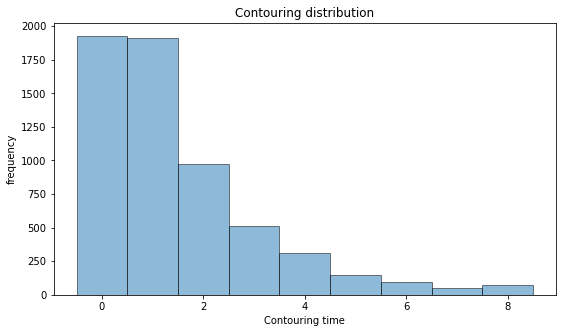

In [515]:
#df1920["ContourDur"] = df1920["ContourDur"].fillna(df1920["ContourDur"].mode()[0])

plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["ContourDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

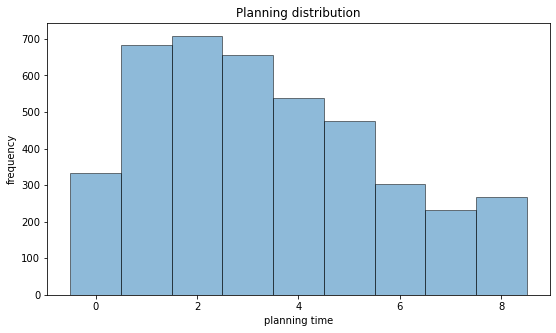

In [518]:
df1920['PlanDur'] = df1920["FinalPlan-Contour"]
#df1920["PlanDur"] = df1920["PlanDur"].fillna(df1920["PlanDur"].mode()[0])
#df1920=df1920[df1920['WaitTime']<=14]

plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["PlanDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### contouring

In [519]:
target_y = "ContourDur"
#df_meet = df1920[df1920['WaitTime']<=14]
features = ['SiteGroup', 'Category_x','TltDose','TxFracs']
df_clf = df1920[features + [target_y]]


In [520]:
# drop rows if ContourDur is na
df_clf = df_clf[df_clf['ContourDur'].notna()]
df_clf['ContourDur'].isna()

5        False
11       False
16       False
34       False
46       False
         ...  
57707    False
57716    False
57720    False
57721    False
57743    False
Name: ContourDur, Length: 6102, dtype: bool

In [521]:
df_clf["SiteGroup"] = df_clf["SiteGroup"].fillna(df_clf["SiteGroup"].mode())
df_clf["Category_x"] = df_clf["Category_x"].fillna(df_clf["Category_x"].mode())
df_clf["TltDose"] = df_clf["TltDose"].fillna(df_clf["TltDose"].mode()[0])
df_clf["TxFracs"] = df_clf["TxFracs"].fillna(df_clf["TxFracs"].mode()[0])
#df_clf['Intent'] = df_clf['Intent'].fillna(df_clf['Intent'].mode()[0])
#df_clf['ContourDur'] = df_clf["ContourDur"].fillna(df_clf["ContourDur"].median())

In [522]:
#df_clf["Intent"].isnull().values.any()

In [523]:
dummy = pd.get_dummies(df_clf[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_cont = pd.concat([df_clf, dummy], axis=1)
#print( df_clf.filter(like="Sitegroup_y",axis=1).head() )

## drop the original categorical column
df_cont = df_cont.drop(['SiteGroup','Category_x'], axis=1)

In [524]:
# train-test split
df_train, df_test = model_selection.train_test_split(df_cont, test_size=0.3, random_state=1)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())

X_train shape: (4271, 19) | X_test shape: (1831, 19)
y_train mean: 1.66 | y_test mean: 1.67
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Site_Unknown', 'Categ_Standard 3', 'Categ_Urgent 2']


#### Quantile regression

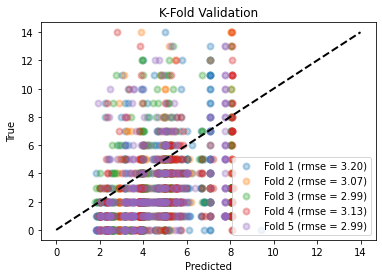

In [526]:
# Quantile regression
## call model
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0, loss = 'quantile', alpha = 0.8)
## K fold validation
scores = []
rmse_list = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    #score = metrics.r2_score(true, prediction)
    #scores.append(score)
    rmse = mean_squared_error(true, prediction, squared=False)
    rmse_list.append(rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (rmse = %0.2f)' % (i, rmse))
                #label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
    
### plotting predicted values against the actual Y
### Ideally, points should be all close to a diagonal line where predicted = actual
#plt.figure(figsize=[7,5])
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend(loc = "lower right")

plt.show()



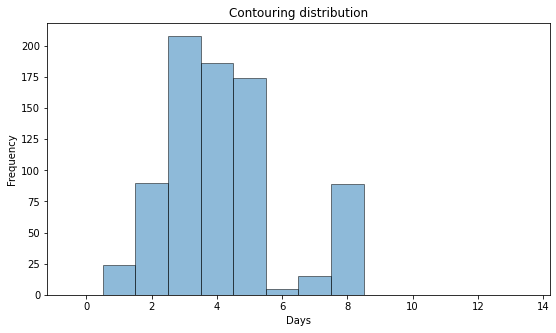

In [528]:
## Quantile regression
qr_model = GradientBoostingRegressor(loss = 'quantile', alpha = 0.8, random_state=0)
qr_model.fit(X_train,y_train)

y_test_pred = qr_model.predict(X_test)
plt.figure(figsize=[9,5])
bins = range(0,15)

y = y_test_pred
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### Classification continued

In [347]:
df_test_copy = df_test

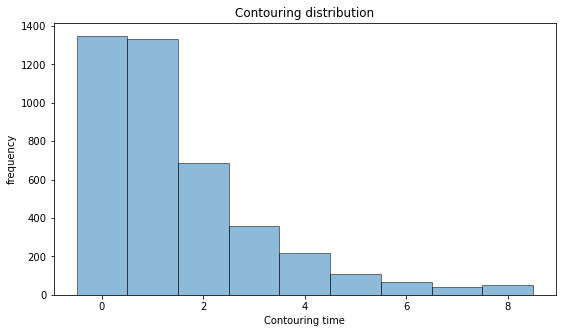

In [354]:
df_train[target_y]
plt.figure(figsize=[9,5])
bins = range(0,10)

y = df_train[target_y]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [349]:
# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=1, 'ContourGroup'] = 0
df_train.loc[(df_train[target_y] >=2)&(df_train[target_y] <=3), 'ContourGroup'] = 1
df_train.loc[df_train[target_y] >= 4, 'ContourGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <= 1, 'ContourGroup'] = 0
df_test.loc[(df_test[target_y] >=2)&(df_test[target_y] <=3), 'ContourGroup'] = 1
df_test.loc[df_test[target_y] >=3, 'ContourGroup'] = 2
df_test = df_test.drop(columns=[target_y])

In [355]:
# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=0, 'ContourGroup'] = 0
df_train.loc[df_train[target_y] ==1, 'ContourGroup'] = 1
df_train.loc[df_train[target_y] >= 2, 'ContourGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <=0, 'ContourGroup'] = 0
df_test.loc[df_test[target_y] ==1, 'ContourGroup'] = 1
df_test.loc[df_test[target_y] >=2, 'ContourGroup'] = 2
df_test = df_test.drop(columns=[target_y])

In [356]:
X_train = df_train.drop('ContourGroup', axis=1).values
y_train = df_train['ContourGroup'].values

X_test = df_test.drop('ContourGroup', axis=1).values
y_test = df_test['ContourGroup'].values
feature_names = df_train.drop('ContourGroup', axis=1).columns.tolist()

In [357]:
### Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)

y_pred = clf_rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5013653741125068


In [358]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [359]:
# evaluate random search
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [360]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [361]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [362]:
grid_search.score(X_test, y_test)

0.537411250682687

In [363]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[367 119 102]
 [194 163 223]
 [ 86 123 454]]
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59       588
         1.0       0.40      0.28      0.33       580
         2.0       0.58      0.68      0.63       663

    accuracy                           0.54      1831
   macro avg       0.52      0.53      0.52      1831
weighted avg       0.52      0.54      0.52      1831



In [374]:
### RMSE (days)
y_pred_days = []
for i in y_pred: #y_rf_pred:
    if i == 0:
        y_pred_days.append(0)
    if i == 1:
        y_pred_days.append(1)       
    if i == 2:
        y_pred_days.append(3)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error

#pred_filtered = y_pred_days.remove(3)
#true_filtered = [x for x in y_true_days if x <= 2]

rmse = mean_squared_error(y_pred_days, y_true_days, squared=False)
#rmse = mean_squared_error(pred_filter, true_filtered, squared=False)
print(rmse)

3.7646491586628446


In [207]:
'''# save the model
from pickle import dump
dump(grid_search, open('Contouring_model.pkl', 'wb'))'''

#### ContourGroup rules

In [365]:
a = df_cont[df_cont[target_y]==1][target_y]
np.percentile(a, 75)

1.0

In [435]:
b = df_cont[(df_cont[target_y]<=3)&(df_cont[target_y]>=2)][target_y]
np.percentile(b, 75)

3.0

In [369]:
c = df_cont[df_cont[target_y]>=2][target_y]
np.percentile(c, 50)


3.0

### Predict Instance Data

In [529]:
all_columns = df_train.columns # index object
model_features = df_train.columns.to_list()
model_features.remove(target_y)

In [530]:
df_ins.head()

,Unnamed: 0,MRN,CreatedDate,SiteGroup,Intent1,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,...,Intent_x,ContrM,Plan75p,Plan80p,Plan90p,Intent_y,PlanM,preTxDays_75,preTxDays_80,preTxDays_90
0,0,7287,2019-02-20,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,...,Palliative,0.0,0.0,0.0,1.0,Palliative,0.0,0.0,0.0,1.0
1,2,7287,2019-07-31,GENITOURINARY(GU),Palliative,Urgent 2,30,2500,10,30,...,Palliative,0.0,0.0,0.0,1.0,Palliative,0.0,0.0,0.0,1.0
2,3,7287,2019-08-28,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,...,Palliative,0.0,0.0,0.0,1.0,Palliative,0.0,0.0,0.0,1.0
3,11,160063,2019-12-02,GENITOURINARY(GU),Palliative,Urgent 2,30,2000,5,30,...,Palliative,0.0,0.0,0.0,1.0,Palliative,0.0,0.0,0.0,1.0
4,12,160063,2020-07-13,GENITOURINARY(GU),Palliative,Urgent 2,30,800,1,30,...,Palliative,0.0,0.0,0.0,1.0,Palliative,0.0,0.0,0.0,1.0


In [531]:
dfDur = df_ins[['SiteGroup','Category_x','TltDose','TxFracs']]
dummy_new = pd.get_dummies(dfDur[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_new = pd.concat([dfDur, dummy_new], axis=1)
## drop the original categorical column
df_new = df_new.drop(['SiteGroup','Category_x'], axis=1)
df_new = df_new.reindex(columns = df_new.columns | all_columns)
df_new.fillna(0, inplace=True)
df_new = df_new[model_features]

In [532]:
df_ins['Contour'] = qr_model.predict(df_new)

In [488]:
#df_new = df_new.reindex(columns = df_new.columns | all_columns)
#df_new.fillna(0, inplace=True)
#df_new = df_new[model_features]

In [416]:
'''X_new = df_new.values
y_new_pred = qr_model.predict(X_new)
df_ins['Contour'] = y_new_pred'''

In [489]:
'''X_new = df_new.values
y_new_pred = grid_search.predict(X_new)
y_new_days = []
for i in y_new_pred:
    if i == 0:
        y_new_days.append(1)
    if i == 1:
        y_new_days.append(3)       
    if i == 2:
        y_new_days.append(4)
df_ins['Contour'] = y_new_days'''

### Planning

In [533]:
# remove outliers by planning time\
df_meet['z_score_contour']=stats.zscore(df_meet['PlanDur'])
#df_meet = df_meet.loc[df_meet['z_score_contour'].abs()<=3]


In [534]:
#df_meet[df_meet['PlanDur'].notnull()].shape
target_y='PlanDur'
features = ['SiteGroup', 'Category_x','TltDose','TxFracs']
df_clf2 = df1920[features + [target_y]]
df_clf2 = df_clf2[df_clf2['PlanDur'].notnull()]
df_clf2.head()

,SiteGroup,Category_x,TltDose,TxFracs,PlanDur
5,GENITOURINARY(GU),Urgent 2,1600.0,2.0,0.0
11,BREAST,Standard 3,4240.0,16.0,4.0
16,BREAST,Standard 3,4240.0,16.0,1.0
34,BREAST,Standard 3,4240.0,16.0,6.0
46,SARCOMA,Standard 3,6600.0,33.0,4.0


In [535]:
target_y = "PlanDur"
features = ['SiteGroup','Category_x','TltDose','TxFracs']
#df_clf2 = df_meet[features + [target_y]]
df_clf2 = df_clf2[df_clf2['SiteGroup'].notnull()]
df_clf2["SiteGroup"] = df_clf2["SiteGroup"].fillna(df_clf2["SiteGroup"].mode())
df_clf2["Category_x"] = df_clf2["Category_x"].fillna(df_clf2["Category_x"].mode())
df_clf2["TltDose"] = df_clf2["TltDose"].fillna(df_clf2["TltDose"].mode()[0])
df_clf2["TxFracs"] = df_clf2["TxFracs"].fillna(df_clf2["TxFracs"].median())
#df_clf2[target_y] = df_clf2[target_y].fillna(df_clf2[target_y].mode()[0])

In [536]:
for column in df_clf2.columns:
    df_clf2[column].fillna(df_clf2[column].mode()[0], inplace=True)

In [537]:
# created binary dataframe
dummy = pd.get_dummies(df_clf2[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_plan = pd.concat([df_clf2, dummy], axis=1)
## drop the original categorical column
df_plan = df_plan.drop(['SiteGroup','Category_x'], axis=1)
df_plan.head()

,TltDose,TxFracs,PlanDur,Site_BREAST,Site_CNS,Site_ENDOCRINE,Site_ENT (HEAD & NECK),Site_EYE,Site_GENITOURINARY(GU),Site_GI LOWER,Site_GI UPPER,Site_GYNAE,Site_LUNG,Site_LYMPHOMA,Site_PAEDIATRIC,Site_SARCOMA,Site_SKIN,Site_Unknown,Categ_Standard 3,Categ_Urgent 2
5,1600.0,2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
11,4240.0,16.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16,4240.0,16.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
34,4240.0,16.0,6.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
46,6600.0,33.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [538]:
# train-test split
df_train, df_test = model_selection.train_test_split(df_plan, test_size=0.3)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())
df_test_copy = df_test

X_train shape: (3444, 19) | X_test shape: (1476, 19)
y_train mean: 6.83 | y_test mean: 8.37
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Site_Unknown', 'Categ_Standard 3', 'Categ_Urgent 2']


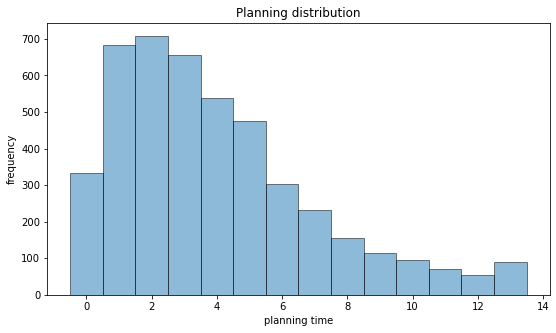

In [539]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_plan[target_y]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### Classification

In [317]:
# quantiles
np.quantile(df_plan[target_y], [0.25,0.5,0.75])

array([1., 2., 4.])

In [122]:
'''# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=2, 'PlanGroup'] = 0
df_train.loc[(df_train[target_y] <=5)&(df_train[target_y]>=3), 'PlanGroup'] = 1
df_train.loc[df_train[target_y] >=6, 'PlanGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <=2, 'PlanGroup'] = 0
df_test.loc[(df_test[target_y] <=5)&(df_test[target_y]>=3), 'PlanGroup'] = 1
df_test.loc[df_test[target_y] >=6, 'PlanGroup'] = 2
df_test = df_test.drop(columns=[target_y])'''


In [318]:
target_y

'PlanDur'

In [319]:
X_train = df_train.drop(target_y, axis=1).values
y_train = df_train[target_y].values

X_test = df_test.drop(target_y, axis=1).values
y_test = df_test[target_y].values
feature_names = df_train.drop(target_y, axis=1).columns.tolist()


In [320]:
### simple Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf2.fit(X_train,y_train)

y_pred = clf_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.26480836236933797


In [321]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 40, 60],
    'max_features': [4, 5, 6, 7, 8],
    'min_samples_leaf': [4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [323]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


#best_grid = grid_search.best_estimato



Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 40, 60],
                         'max_features': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 5, 6, 7, 8],
                         'min_samples_split': [5, 10, 12, 15],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [324]:
grid_search.score(X_test, y_test)

0.27177700348432055

In [325]:
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 72 31  7  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30 35  9  5  5  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15 36 20  6  4  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3 22 14 11 13  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 15  7 12 14  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 15 13  8 25  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  6  3 13  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  8

/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [326]:
rmse = mean_squared_error(y_rf_pred, y_test,squared=False)
print(rmse)

3.503855517044126


#### Planning rules

In [ ]:
a = df_plan[df_plan[target_y]<=0][target_y]
print(np.percentile(a, 90))
b = df_plan[(df_plan[target_y]<=1)&(df_plan[target_y]>=1)][target_y]
print(np.percentile(b, 90))
c = df_plan[df_plan[target_y]>=2][target_y]
print(np.percentile(c, 75))


#### rmse # days

In [ ]:
y_pred_days = []
for i in y_rf_pred:
    if i == 0:
        y_pred_days.append(0)
    if i == 1:
        y_pred_days.append(1)       
    if i == 2:
        y_pred_days.append(8)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred_days, y_true_days,squared=False)
print(rmse)


### Regression

In [540]:
df_plan = df_plan[(df_plan['PlanDur']>=0)&(df_plan['PlanDur']<=14)]
df_plan.shape

(4505, 20)

In [541]:
for column in df_plan.columns:
    df_plan[column].fillna(df_plan[column].median(), inplace=True)


In [542]:
df_plan = df_plan.dropna()

In [554]:
# train-test split
target_y = 'PlanDur'
df_plan = df_plan[df_plan['PlanDur']>=0]
df_train, df_test = model_selection.train_test_split(df_plan, test_size=0.3, random_state=10)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())
df_test_copy = df_test

X_train = df_train.drop('PlanDur', axis=1).values
y_train = df_train['PlanDur'].values

X_test = df_test.drop('PlanDur', axis=1).values
y_test = df_test['PlanDur'].values
feature_names = df_train.drop('PlanDur', axis=1).columns.tolist()

X_train shape: (3153, 19) | X_test shape: (1352, 19)
y_train mean: 3.95 | y_test mean: 3.99
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Site_Unknown', 'Categ_Standard 3', 'Categ_Urgent 2']


In [557]:
X_train.shape

(3153, 19)

In [558]:
## Quantile Regression
import statsmodels.api as sm
quantreg = sm.QuantReg(y_train, X_train)
model_qr = quantreg.fit(q=0.80)
#y_pred = model_qr.predict(X_test)



ValueError: operands could not be broadcast together with shapes (19,) (17,) 

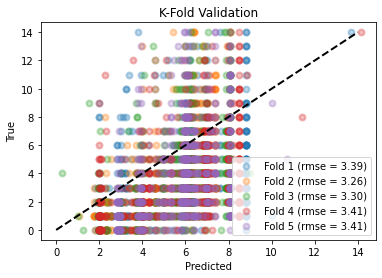

In [545]:
## call model
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0, loss = 'quantile', alpha = 0.8)
## K fold validation
scores = []
rmse_list = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    #score = metrics.r2_score(true, prediction)
    #scores.append(score)
    rmse = mean_squared_error(true, prediction, squared=False)
    rmse_list.append(rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (rmse = %0.2f)' % (i, rmse))
                #label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
    
### plotting predicted values against the actual Y
### Ideally, points should be all close to a diagonal line where predicted = actual
#plt.figure(figsize=[7,5])
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend(loc = "lower right")

plt.show()

In [547]:
QRmodel = GradientBoostingRegressor(random_state=0, loss = 'quantile', alpha = 0.8)
QRmodel.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
rmse = mean_squared_error(y_test_pred, y_test,squared=False)
print(rmse)

3.419421054542202


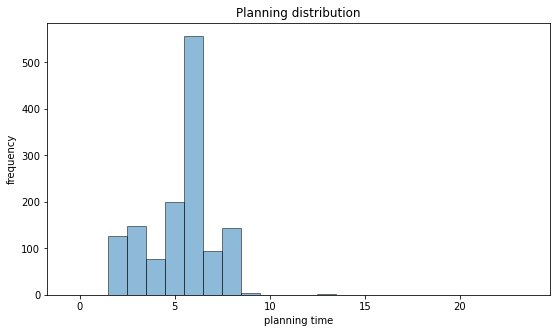

In [548]:

plt.figure(figsize=[9,5])
bins = range(0,25)

y = y_test_pred
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [ ]:
## predicting the new ins data


In [104]:
'''import math
y_pred_days = [round(i) for i in y_test_pred]
y_pred_days'''

'import math\ny_pred_days = [round(i) for i in y_test_pred]\ny_pred_days'

In [518]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'learning_rate':[0.001, 0.01, 0.1],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}
# Create a based model
gb = GradientBoostingRegressor(random_state=1)
# Instantiate the grid search model
gb_grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_root_mean_squared_error')
# Fit the grid search to the data
gb_grid_search.fit(X_train, y_train)
gb_grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 5, 'n_estimators': 200}

In [519]:
y_test_pred = gb_grid_search.predict(X_test)
rmse = mean_squared_error(y_test_pred, y_test,squared=False)
print(rmse)

3.09252888839197


### Instance data

In [549]:
bi_features = df_train.columns
df_new = df_ins
df_new = df_new.reindex(columns=df_new.columns | df_train.columns)
df_new.fillna(0, inplace=True)
df_new = df_new[bi_features.drop('PlanDur')]
df_new

,TltDose,TxFracs,Site_BREAST,Site_CNS,Site_ENDOCRINE,Site_ENT (HEAD & NECK),Site_EYE,Site_GENITOURINARY(GU),Site_GI LOWER,Site_GI UPPER,Site_GYNAE,Site_LUNG,Site_LYMPHOMA,Site_PAEDIATRIC,Site_SARCOMA,Site_SKIN,Site_Unknown,Categ_Standard 3,Categ_Urgent 2
0,1600,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1600,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,800,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,2000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11799,1200,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11800,3600,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11801,540,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [550]:
X_new = df_new.values
y_new_pred = model.predict(X_new)
#gb_grid_search.predict(X_new)

df_ins['Plan'] = y_new_pred.round(0)

In [551]:
df_ins['preTxDays']=df_ins['Plan']+df_ins['Contour']
df_ins

,Unnamed: 0,MRN,CreatedDate,SiteGroup,Intent1,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,...,Plan80p,Plan90p,Intent_y,PlanM,preTxDays_75,preTxDays_80,preTxDays_90,Contour,Plan,preTxDays
0,0,7287,2019-02-20,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,...,0.0,1.0,Palliative,0.0,0.0,0.0,1.0,2.356854,4.0,6.356854
1,2,7287,2019-07-31,GENITOURINARY(GU),Palliative,Urgent 2,30,2500,10,30,...,0.0,1.0,Palliative,0.0,0.0,0.0,1.0,4.849468,6.0,10.849468
2,3,7287,2019-08-28,GENITOURINARY(GU),Palliative,Urgent 2,30,1600,2,30,...,0.0,1.0,Palliative,0.0,0.0,0.0,1.0,2.356854,4.0,6.356854
3,11,160063,2019-12-02,GENITOURINARY(GU),Palliative,Urgent 2,30,2000,5,30,...,0.0,1.0,Palliative,0.0,0.0,0.0,1.0,2.356854,4.0,6.356854
4,12,160063,2020-07-13,GENITOURINARY(GU),Palliative,Urgent 2,30,800,1,30,...,0.0,1.0,Palliative,0.0,0.0,0.0,1.0,2.437982,4.0,6.437982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,15182,4384853,2019-06-20,PAEDIATRIC,Complex Palliation,Urgent 2,30,2000,5,30,...,1.2,2.3,Complex Palliation,0.0,0.5,1.2,2.6,2.329985,4.0,6.329985
11799,15231,4539330,2018-05-02,PAEDIATRIC,Complex Palliation,Urgent 2,30,1200,6,45,...,1.2,2.3,Complex Palliation,0.0,0.5,1.2,2.6,2.230816,5.0,7.230816
11800,15266,4580417,2019-11-05,PAEDIATRIC,Complex Palliation,Urgent 2,30,3600,20,30,...,1.2,2.3,Complex Palliation,0.0,0.5,1.2,2.6,4.131718,6.0,10.131718
11801,15303,4619093,2019-06-17,PAEDIATRIC,Complex Palliation,Urgent 2,30,540,3,30,...,1.2,2.3,Complex Palliation,0.0,0.5,1.2,2.6,2.070687,4.0,6.070687


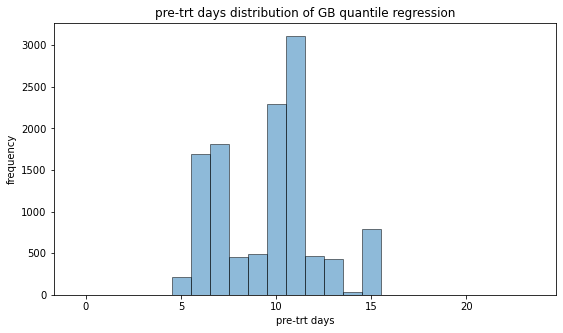

In [552]:
plt.figure(figsize=[9,5])
bins = range(0,25)

y = df_ins['preTxDays']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('pre-trt days')
plt.ylabel('frequency')
plt.title('pre-trt days distribution of GB quantile regression')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [455]:
#df_ins.to_excel(output_file_name)
df_ins.to_excel("ins_2018_2019_part2_GBQR.xlsx")

In [ ]:
#df1920[df1920['Team']==1][['SimLocation','TxUnit']]

In [237]:
df_ins.SiteGroup.unique()

array(['CNS', 'Head & Neck', 'Gynae', 'Breast', 'GI Upper', 'Sarcoma',
       'Endocrine', 'Lung', 'Lymphoma', 'Paediatrics'], dtype=object)

# Simple Analysis

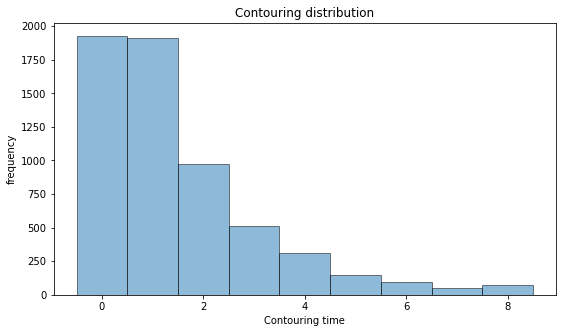

In [562]:
plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["ContourDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')


plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [563]:
df1920["PlanDur"].size

7781

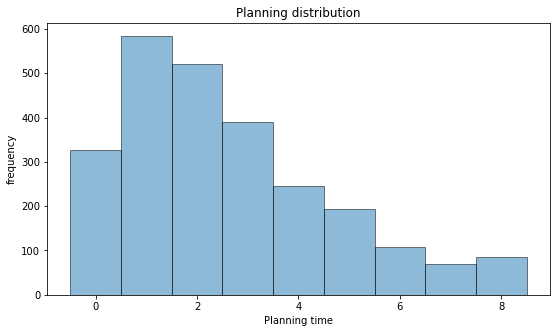

In [459]:
plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["PlanDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [564]:
#df_ins = pd.read_excel('ins_201910_202002_part1.xlsx')
#df_ins.rename(columns={"Category_x": "Category"})
df_orig.shape

(44622, 82)

In [565]:
df_1920 = df_orig[(df_orig['CreatedDate']>='2017-01-01')&(df_orig['CreatedDate']<='2021-01-01')]
df_1920.shape

(16084, 82)

In [566]:
sitegroups = df_1920['SiteGroup'].unique()
categories = df_1920['Category_x'].unique()
intents = df_1920['Intent1'].unique()
intents = intents[~pd.isnull(intents)]

In [567]:
intents

array(['Palliative', 'Radical', 'Complex Palliation'], dtype=object)

In [568]:
# planning
list_todf = []
for s in sitegroups:
    for c in categories:
        for i in intents:
            #print(s, c, i)
            df_temp = df_1920[(df_1920['SiteGroup']==s)&(df_1920['Category_x']==c)&(df_1920['Intent1']==i)]
            df_temp['PlanDur'].fillna(df_temp['PlanDur'].median(), inplace=True) # fill na using mean
            p_90 = df_temp['PlanDur'].quantile(.9)
            p_80 = df_temp['PlanDur'].quantile(.8)
            p_75 = df_temp['PlanDur'].quantile(.75)
            p_med = df_temp['PlanDur'].median()
            new_row = [s, c, i, p_90, p_80, p_75, p_med]
            list_todf.append(new_row)
df_simplePlan = pd.DataFrame(list_todf, columns =['SiteGroup','Category','Intent','90p','80p','75p','m'])

df_toFill = df_simplePlan[df_simplePlan['90p'].isna()]
df_simplePlan = df_simplePlan.dropna()

# fill na using mean of this sitegroup and category
for s in df_toFill['SiteGroup'].unique():
    for c in df_toFill['Category'].unique():
        mean = df_1920[(df_1920['SiteGroup']==s)&(df_1920['Category_x']==c)]['PlanDur'].mean()
        df_filled = df_toFill[(df_toFill['SiteGroup']==s)&(df_toFill['Category']==c)].fillna(mean)
        df_simplePlan = df_simplePlan.append(df_filled, sort=True)

In [309]:
#df_simplePlan.to_excel('Planning_Simple_Rule_since18.xlsx')


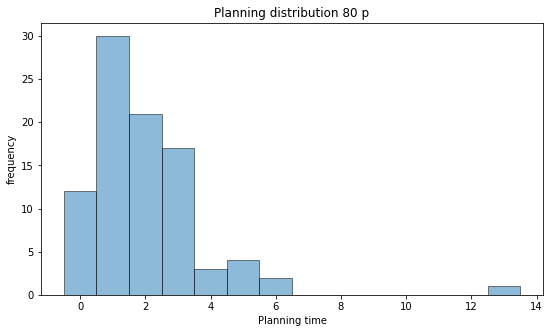

In [569]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_simplePlan['80p']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Planning time')
plt.ylabel('frequency')
plt.title('Planning distribution 80 p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


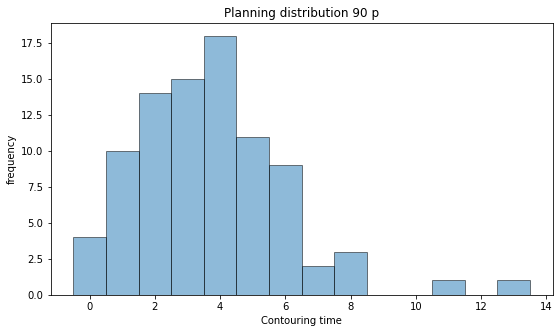

In [570]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_simplePlan['90p']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Planning distribution 90 p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [571]:
# contouring
list_todf = []
# compute 90 anf 75 percentile based on [sitegroup, category, intent]
for s in sitegroups:
    for c in categories:
        for i in intents:
            #print(s, c, i)
            df_temp = df_1920[(df_1920['SiteGroup']==s)&(df_1920['Category_x']==c)&(df_1920['Intent1']==i)]
            df_temp['ContourDur'].fillna(df_temp['ContourDur'].median(), inplace=True) # fill na using mean
            p_90 = df_temp['ContourDur'].quantile(.9)
            p_80 = df_temp['ContourDur'].quantile(.8)
            p_75 = df_temp['ContourDur'].quantile(.75)
            p_med = df_temp['ContourDur'].median()
            new_row = [s, c, i, p_90, p_80, p_75, p_med]
            list_todf.append(new_row)
df_simpleContour = pd.DataFrame(list_todf, columns =['SiteGroup','Category','Intent','90p','80p','75p', 'm'])

df_toFill = df_simpleContour[df_simpleContour['90p'].isna()]
df_simpleContour = df_simpleContour.dropna()

# fill na using mean of this [sitegroup, category]
for s in df_toFill['SiteGroup'].unique():
    for c in df_toFill['Category'].unique():
        mean = df_1920[(df_1920['SiteGroup']==s)&(df_1920['Category_x']==c)]['PlanDur'].mean()
        df_filled = df_toFill[(df_toFill['SiteGroup']==s)&(df_toFill['Category']==c)].fillna(mean)
        df_simpleContour = df_simpleContour.append(df_filled, sort=True)

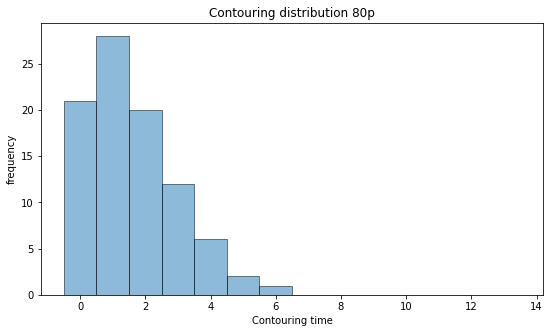

In [572]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_simpleContour['80p']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution 80p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

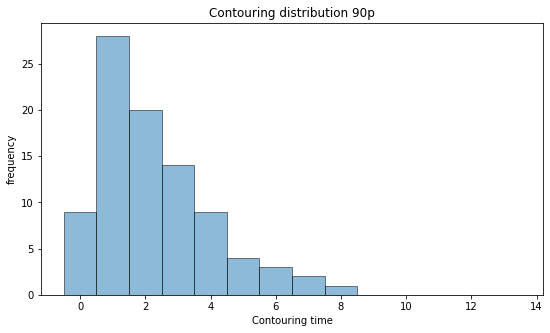

In [573]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_simpleContour['90p']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution 90p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [574]:
#df_ins = pd.read_excel('ins_2018_2020_part1.xlsx')
df_ins = pd.read_excel('ins_2018_2020_heuristics.xlsx')

In [575]:
df_ins['Intent1'].unique()

array(['Radical', 'Complex Palliation', 'Palliative'], dtype=object)

In [576]:
df_ins = df_ins.merge(df_simpleContour, left_on=['SiteGroup','Category_x','Intent1'], right_on=['SiteGroup','Category','Intent'])
df_ins = df_ins.rename(columns={"75p":"Contr75p","80p":"Contr80p", "90p":"Contr90p", 'm':'ContrM'})
df_ins = df_ins.drop(columns=['Category'])


In [577]:
df_ins = df_ins.merge(df_simplePlan, left_on=['SiteGroup','Category_x','Intent1'], right_on=['SiteGroup','Category','Intent'])
df_ins = df_ins.rename(columns={"75p":"Plan75p", "80p":"Plan80p", "90p":"Plan90p", 'm':"PlanM"})
df_ins = df_ins.drop(columns=['Category'])


In [578]:
df_ins['preTxDays_75'] = df_ins['Contr75p']+df_ins['Plan75p']
df_ins['preTxDays_80'] = df_ins['Contr80p']+df_ins['Plan80p']
df_ins['preTxDays_90'] = df_ins['Contr90p']+df_ins['Plan90p']
df_ins

,MRN,CreatedDate,SiteGroup,Intent1,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,TxUnit,...,Intent_x,ContrM,Plan75p,Plan80p,Plan90p,Intent_y,PlanM,preTxDays_75,preTxDays_80,preTxDays_90
0,2626026,2018-01-01,GENITOURINARY(GU),Radical,Standard 3,30,5400,27,30,NA09,...,Radical,2.0,2.00,2.0,6.0,Radical,1.0,5.000,5.0,10.00
1,4253349,2018-01-02,GENITOURINARY(GU),Radical,Standard 3,15,6600,33,30,SV02,...,Radical,2.0,2.00,2.0,6.0,Radical,1.0,5.000,5.0,10.00
2,4398204,2018-01-02,GENITOURINARY(GU),Radical,Standard 3,20,6600,33,30,SV02,...,Radical,2.0,2.00,2.0,6.0,Radical,1.0,5.000,5.0,10.00
3,4228163,2018-01-04,GENITOURINARY(GU),Radical,Standard 3,15,6600,33,30,SV02,...,Radical,2.0,2.00,2.0,6.0,Radical,1.0,5.000,5.0,10.00
4,158696,2018-01-04,GENITOURINARY(GU),Radical,Standard 3,30,6000,20,30,NA09,...,Radical,2.0,2.00,2.0,6.0,Radical,1.0,5.000,5.0,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,4713585,2020-11-04,PAEDIATRIC,Complex Palliation,Standard 3,45,2000,5,30,NA12,...,Complex Palliation,1.5,2.75,3.0,26.5,Complex Palliation,2.0,5.500,6.0,29.50
11799,4596312,2018-12-12,GI LOWER,Radical,Urgent 2,45,3600,20,30,NA11,...,Radical,3.5,2.50,2.8,3.4,Radical,2.0,6.625,7.3,8.65
11800,4786080,2020-10-21,GI LOWER,Radical,Urgent 2,45,4500,25,30,NA10,...,Radical,3.5,2.50,2.8,3.4,Radical,2.0,6.625,7.3,8.65
11801,3113781,2020-01-21,EYE,Complex Palliation,Urgent 2,30,2000,5,30,NA09,...,Complex Palliation,0.0,0.00,0.0,0.0,Complex Palliation,0.0,0.000,0.0,0.00


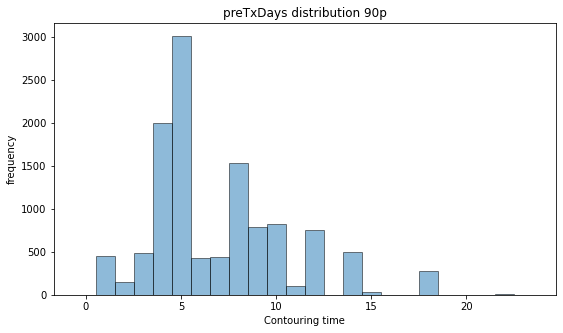

In [579]:
plt.figure(figsize=[9,5])
bins = range(0,25)

y = df_ins['preTxDays_90']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('preTxDays distribution 90p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


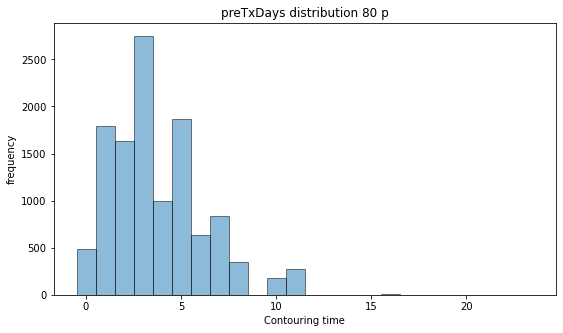

In [580]:
plt.figure(figsize=[9,5])
bins = range(0,25)

y = df_ins['preTxDays_80']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('preTxDays distribution 80 p')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [581]:
### Some outliers feature groups
### 1. GENITOURINARY(GU), Complex Palliation, Standard 3: 9.27, 9.27
### 2. LYMPHOMA, Radical, Standard 3: 1, 23.78
### 3. LYMPHOMA,  Complex Palliation, Standard 3: 22, 22
df_ins[df_ins['preTxDays']>20][['SiteGroup','Intent1','Category_x','Contr75p','Plan75p']]

KeyError: 'preTxDays'

In [582]:
df_ins.to_excel('ins_2018_2020_heuristics_part2.xlsx')

In [476]:
#df_ins.to_excel('ins_2018_2020_part2_rules_80p.xlsx')

In [185]:
#df_simpleRule.to_excel('planningTimeSimpleRule.xlsx')

## Quantile regression

In [477]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [478]:
df_q = df_orig[(df_orig['CreatedDate']>='2018-01-01')&(df_orig['CreatedDate']<='2021-01-01')]
df_q.shape

(12046, 82)

In [501]:
df_q['Sitegroup_y'].unique()

array(['GENITOURINARY(GU)', 'BREAST', 'GASTROINTESTINAL(GI)', 'GYNAE',
       'SARCOMA', 'ENT (HEAD & NECK)', 'LUNG', 'CNS', 'LYMPHOMA', 'SKIN',
       'EYE', 'ENDOCRINE', 'LEUKEMIA', 'UNKNOWN', nan, 'PAEDIATRIC',
       'OTHER SITES C76', 'NON CANCER DX'], dtype=object)

In [481]:
df_q.columns

Index(['MRN', 'CreatedDate', 'CreatedTime', 'ActivatedDate', 'ActivatedTime',
       'SiteGroup', 'Diagnosis', 'Category_x', 'PlanCreateDate',
       'PlanCreateTime', 'StartDate', 'ConcurrentTx', 'Intent1', 'Intent2',
       'Team', 'Location_x', 'SimApptDate', 'SimApptTime', 'ApptDtTm',
       'GTV/CTVPromtDate', 'GTV/CTVPromtTime', 'GTV/CTVCompleteDate',
       'GTV/CTVCompleteTime', 'ContourDur', 'FinalPlanPromtDate',
       'FinalPlanPromtTime', 'FinalPlanCompleteDate', 'FinalPlanCompleteTime',
       'FinalPlanAlone', 'FinalPlan-Contour', 'ReviewDatePlaner',
       'ReviewTimePlaner', 'PlanReviewRequestDate', 'PlanReviewRequestTime',
       'PlanProgressReviewDate', 'PlanProgressReviewTime', 'eBookingReviDate',
       'eBookingReviTime', 'COVID19', 'eBookingStatus', 'Unnamed: 37',
       'ApptDtTm.1', 'SimApptDt', 'SimApptTm', 'SimApptDuration',
       'SimApptCreatedDt', 'SimLocation', 'CTWait', 'TxStartDt', 'TxStartDtTm',
       'TxApptDuration', 'TxApptCreatedDt', 'ApptStatus'

In [504]:
model = smf.quantreg('PlanDur ~ Category_x + Intent1 + Sitegroup_y + TltDose + TxFracs', df_q).fit(q=0.9)
#view model summary
print(model.summary())

                         QuantReg Regression Results                          
Dep. Variable:                PlanDur   Pseudo R-squared:              0.01152
Model:                       QuantReg   Bandwidth:                      0.4348
Method:                 Least Squares   Sparsity:                        20.97
Date:                Tue, 27 Jul 2021   No. Observations:                 8537
Time:                        13:52:24   Df Residuals:                     8515
                                        Df Model:                           21
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.0000      0.321     12.454      0.000       3.370       4.630
Category_x[T.Urgent 2]                 -0.9999      0.207     -4.824      0.000      -1.406      -0.594
Intent1[T.Palliative]          

Text(0, 0.5, 'Exam Score')

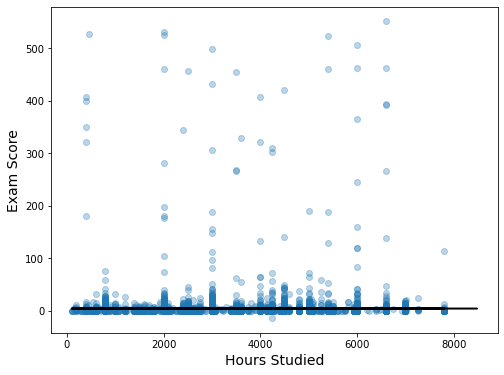

In [505]:
#define figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

#get y values
get_y = lambda a, b: a + b * df_q['TltDose']
y = get_y(model.params['Intercept'], model.params['TltDose'])

#plot data points with quantile regression equation overlaid
ax.plot(df_q['TltDose'], y, color='black')
ax.scatter(df_q['TltDose'], df_q['PlanDur'], alpha=.3)
ax.set_xlabel('Hours Studied', fontsize=14)
ax.set_ylabel('Exam Score', fontsize=14)